In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.utils as image
%matplotlib inline
import seaborn as sns
import cv2
import glob
import random
from os import listdir
import tensorflow.compat.v2 as tf
tf.keras.preprocessing.image.load_img
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


# Reading Dataset

In [ ]:


import glob

# Specify the base path to the dataset
base_path = '/content/breast-histopathology-images'

# Use glob to find all .png files in subdirectories
breast_img = glob.glob(f'{base_path}/**/*.png', recursive=True)

# Print the first three image names
for imgname in breast_img[:3]:
    print(imgname)


In [ ]:
non_cancer = []
with_cancer = []

for img in breast_img:
    if img[-5] == '0' :
        non_cancer.append(img)

    elif img[-5] == '1' :
        with_cancer.append(img)

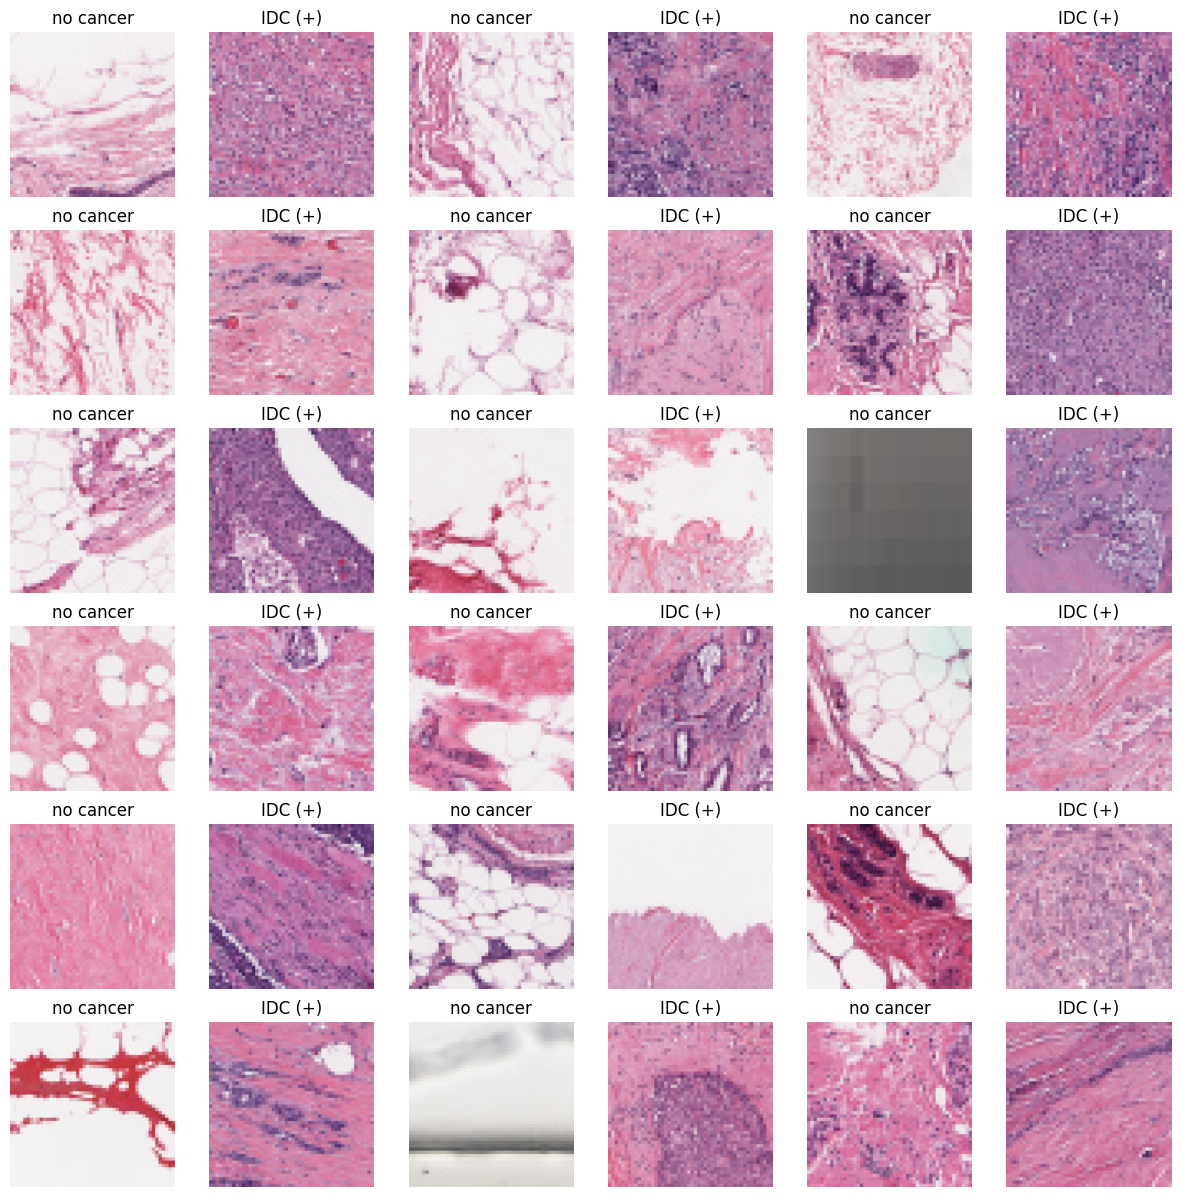

In [ ]:
from keras.preprocessing import image

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(non_cancer), 18)
some_can = np.random.randint(0, len(with_cancer), 18)

s = 0
for num in some_non:

        img = image.load_img((non_cancer[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:

        img = image.load_img((with_cancer[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s)
        plt.axis('off')
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

# Organizing image data using OpenCV

In [ ]:
from PIL import Image
import numpy as np

non_img_arr = []
can_img_arr = []

# Function to load and resize images
def process_image(img_path, label):
    img = Image.open(img_path)
    img = img.resize((50, 50), resample=Image.BILINEAR)
    img_arr = np.array(img)
    return [img_arr, label]

# Process non_cancer images
non_img_arr = [process_image(img, 0) for img in non_cancer]

# Process with_cancer images
can_img_arr = [process_image(img, 1) for img in with_cancer]


In [ ]:
non_img_arr = []
can_img_arr = []

for img in non_cancer:

    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in with_cancer:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

 **Because we have implalanced dataset we will take by hand more cancer images which will increase the accuracy of recall.**

In [ ]:
print('Total cancer images are',len(can_img_arr))
print('Total non cancer images are',len(non_img_arr))

#Reducing size of both image data(non cancer and cancer images)
cancer_image=can_img_arr[0:50000]
no_cancer=non_img_arr[0:50000]
print('\nReduced dataset cancer images ',len(cancer_image))
print('Reduced dataset non cancer images are',len(no_cancer))

Total cancer images are 157572
Total non cancer images are 397476

Reduced dataset cancer images  50000
Reduced dataset non cancer images are 50000


In [ ]:
X = []
y = []

all_image = np.concatenate((no_cancer, cancer_image))
random.shuffle(all_image)

for feature, label in all_image:
    X.append(feature)
    y.append(label)

X = np.array(X)
y = np.array(y)

print('Print total labels: ',len(y))

Print total labels:  100000


In [ ]:
import os
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC negative Images: {}'.format(np.sum(b==0)))
    print('Number of IDC positive Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

Total number of images: 100000
Number of IDC negative Images: 84689
Number of IDC positive Images: 15311
Image shape (Width, Height, Channels): (50, 50, 3)


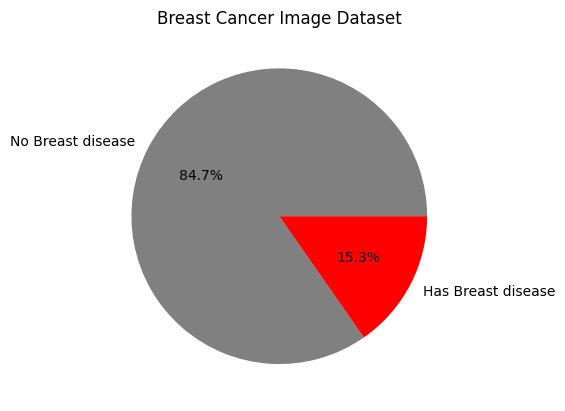

In [ ]:
benign_count = np.sum(y==0)
malignant_count =  np.sum(y==1)


counts = [benign_count, malignant_count]
labels = ['No Breast disease', 'Has Breast disease']
colors = ['grey', 'red']  # Change colors to blue and red

plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors)

plt.title('Breast Cancer Image Dataset')
plt.show()

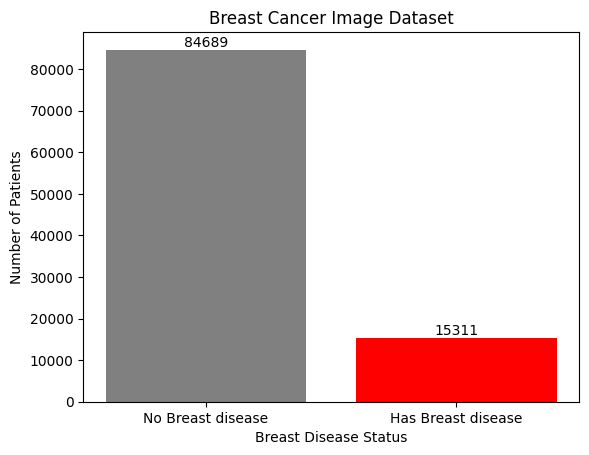

In [ ]:
counts = [benign_count, malignant_count]
labels = ['No Breast disease', 'Has Breast disease']
colors = ['grey', 'red']

plt.bar(labels, counts, color=colors)

# Add data labels
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.title('Breast Cancer Image Dataset')
plt.xlabel('Breast Disease Status')
plt.ylabel('Number of Patients')
plt.show()

## Spliting data in training and testing sets

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Dataset Shape:", X_train.shape)
print("Testing Dataset Shape:", X_test.shape)

Training Dataset Shape: (70000, 50, 50, 3)
Testing Dataset Shape: (30000, 50, 50, 3)


In [ ]:
#minimizing sample size

X_train = X_train[0:50000]
Y_train = Y_train[0:50000]
X_test = X_test[0:30000]
Y_test = Y_test[0:30000]

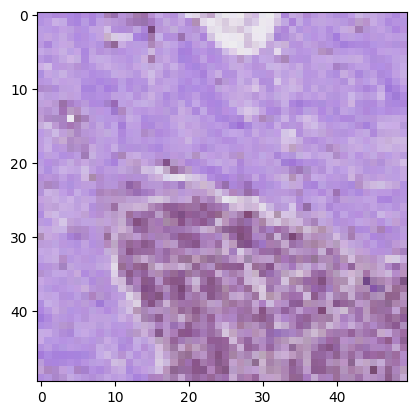

In [ ]:
plt.imshow(X_train[10])

# CNN Model

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=5)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(24, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 50, 50, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 25, 25, 32)        128       
 chNormalization)                                                
                                                        

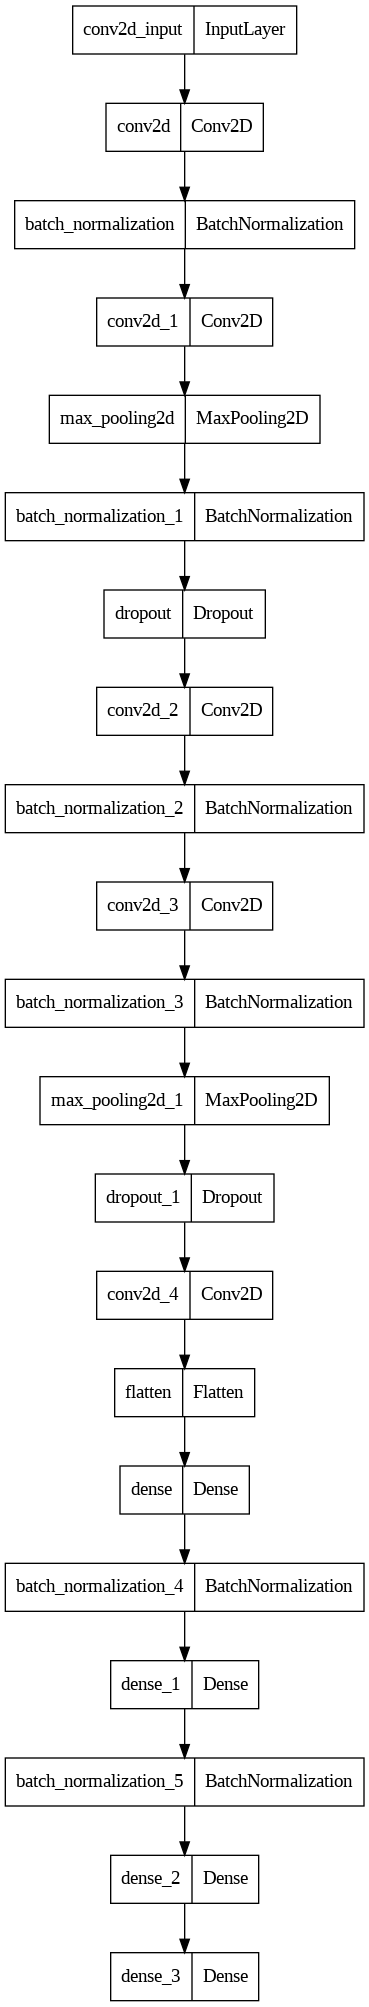

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

## CNN Model Training


In [ ]:
import time
start_time = time.time()

history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 15, batch_size = 35)
# Calculate execution time
execution_time = time.time() - start_time
print(f"Training time: {execution_time:.2f} seconds")

In [ ]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])

index = 90
img_plot(X_test, index)

In [ ]:
input = X_test[index:index+1]
pred = model.predict(input)[0].argmax()
label = Y_test[index].argmax()
print('Predicted Value using  cnn model',pred)
print("True Value",label)

Predicted Value using  cnn model 0
True Value 0


# Resnet Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Defining the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 4s 0us/step


## Resnet Model Training

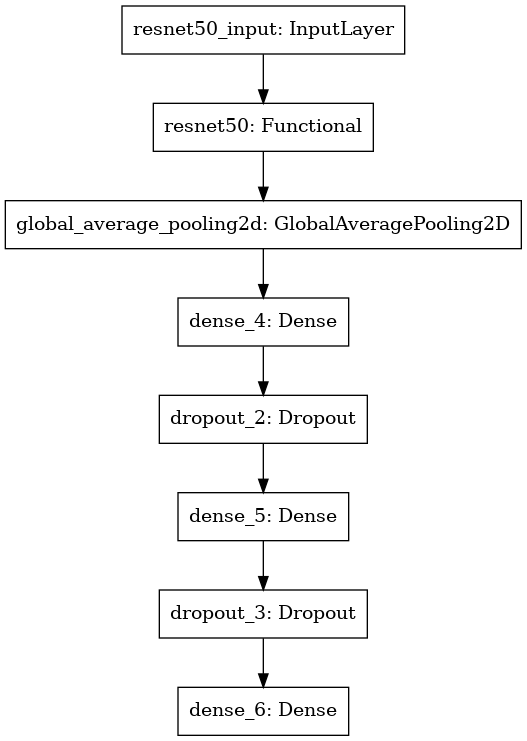

In [ ]:
# Creating a new model on top of the pre-trained model
model1 = models.Sequential()
model1.add(base_model)
model1.add(layers.GlobalAveragePooling2D())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(2, activation='softmax'))

# Compiling the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='model1.png')


In [ ]:
start_time1 = time.time()

history1 = model1.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 15, batch_size = 35)

execution_time1 = time.time() - start_time1
print(f"Training time for Resnet: {execution_time1:.2f} seconds")

Epoch 1/15
1429/1429 [==============================] - 39s 25ms/step - loss: 0.3113 - accuracy: 0.8805 - val_loss: 0.2645 - val_accuracy: 0.8938
Epoch 2/15
1429/1429 [==============================] - 34s 24ms/step - loss: 0.2726 - accuracy: 0.8941 - val_loss: 0.2505 - val_accuracy: 0.9002
Epoch 3/15
1429/1429 [==============================] - 34s 24ms/step - loss: 0.2604 - accuracy: 0.8982 - val_loss: 0.2479 - val_accuracy: 0.9008
Epoch 4/15
1429/1429 [==============================] - 34s 24ms/step - loss: 0.2537 - accuracy: 0.9015 - val_loss: 0.2445 - val_accuracy: 0.9041
Epoch 5/15
1429/1429 [==============================] - 34s 24ms/step - loss: 0.2464 - accuracy: 0.9045 - val_loss: 0.2424 - val_accuracy: 0.9016
Epoch 6/15
1429/1429 [==============================] - 34s 24ms/step - loss: 0.2383 - accuracy: 0.9072 - val_loss: 0.2353 - val_accuracy: 0.9058
Epoch 7/15
1429/1429 [==============================] - 34s 24ms/step - loss: 0.2364 - accuracy: 0.9074 - val_loss: 0.2349 -

# CNN and Resnet Model Performance Evaluation

## Confusion Matrix

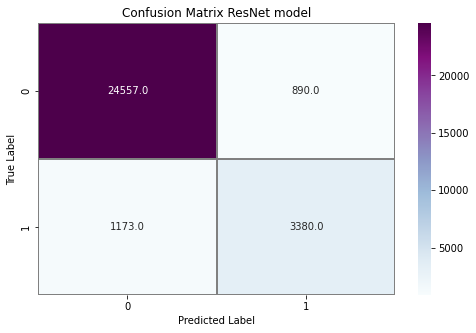

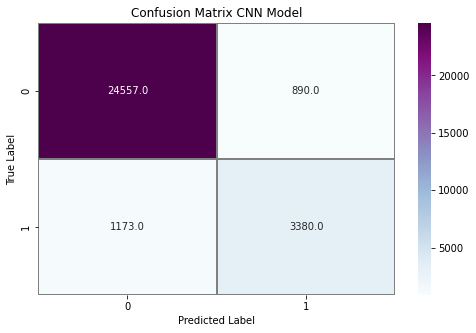

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
Y_pred1 = model.predict(X_test)
Y_pred_classes1 = np.argmax(Y_pred1,axis = 1)
Y_true1 = np.argmax(Y_test,axis = 1)

confusion_mtx = confusion_matrix(Y_true1, Y_pred_classes1)
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix ResNet model")
plt.show()

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(Y_test,axis = 1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CNN Model")
plt.show()

## F1-Score of both models


In [ ]:
Y_true1 = np.argmax(Y_test, axis=1)
Y_pred_classes1 = np.argmax(model1.predict(X_test), axis=1)
Y_pred_classes = np.argmax(model.predict(X_test), axis=1)

f1_score_resnet = f1_score(Y_true1, Y_pred_classes1, average='weighted')
f1_score_cnn = f1_score(Y_true1, Y_pred_classes, average='weighted')

print("F1 Score for CNN Model:", f1_score_cnn)
print("F1 Score for ResNet Model:", f1_score_resnet)

F1 Score for CNN Model: 0.9303206129652887
F1 Score for ResNet Model: 0.9097084250415485


## Performance Plot

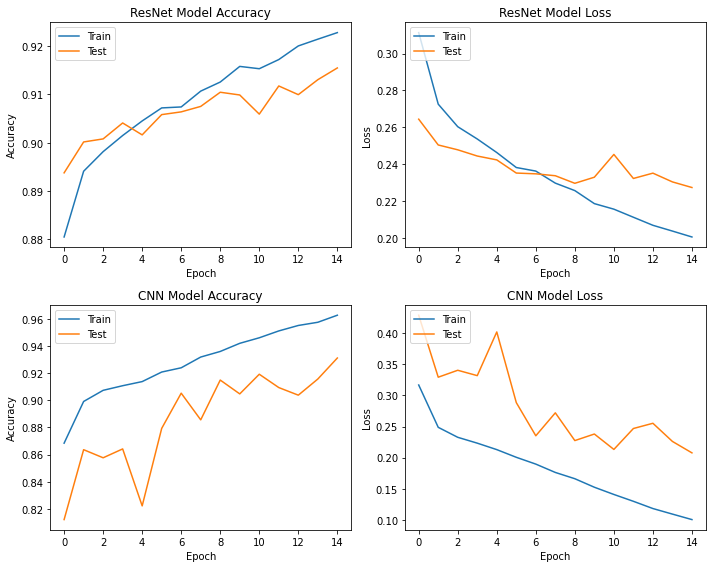

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
# Plot ResNet Model Accuracy
plt.subplot(2, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('ResNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot ResNet Model Loss
plt.subplot(2, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('ResNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot CNN Model Accuracy
plt.subplot(2, 2, 3)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot CNN Model Loss
plt.subplot(2, 2, 4)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()


## CNN MODEL ROC CURVE

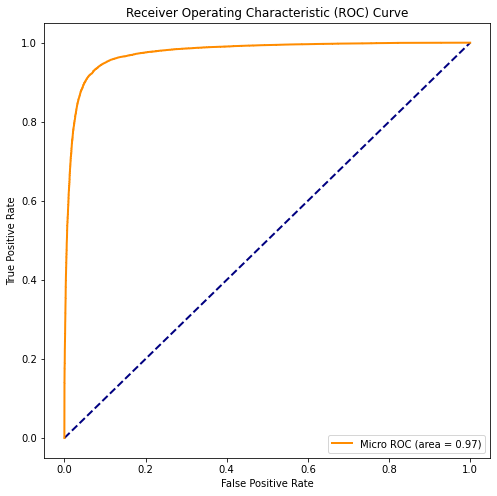

In [ ]:
y_pred = model.predict(X_test)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming Y_test and y_pred are in the multilabel format
fpr, tpr, thresholds = roc_curve(Y_test.ravel(), y_pred.ravel())

roc_auc_micro = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Micro ROC (area = {roc_auc_micro:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## RESNET MODEL ROC CURVE

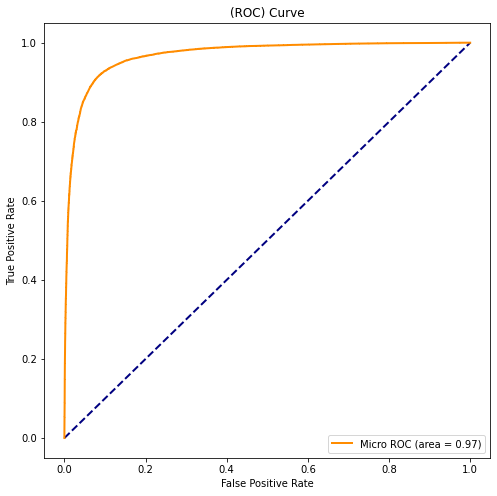

In [ ]:
y_pred1 = model1.predict(X_test)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming Y_test and y_pred are in the multilabel format
fpr, tpr, thresholds = roc_curve(Y_test.ravel(), y_pred1.ravel())

roc_auc_micro1 = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Micro ROC (area = {roc_auc_micro1:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Evaluation Metrics for Training and Test data ('loss', 'accuracy', 'precision', 'recall', 'AUC')

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, AUC

# Compile the models with additional metrics3
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC(name='auc')])
model1.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC(name='auc')])



In [ ]:
# FOR TRAIN DATA
metrics = ['loss', 'accuracy', 'precision', 'recall', 'AUC']

# Evaluate the models
model1_metrics1 = model1.evaluate(X_train, Y_train, verbose=0)
model_metrics1 = model.evaluate(X_train, Y_train, verbose=0)

# Print the metrics

print("For Training Data:\n")
for i, metric in enumerate(metrics):
    print(f"Custom CNN Model {metric}: {model_metrics1[i]}")
    print(f"Resnet Model {metric}: {model1_metrics1[i]}")
    print('\n')


For Training Data:

Custom CNN Model loss: 0.05776870623230934
Resnet Model loss: 0.1695575714111328


Custom CNN Model accuracy: 0.9805399775505066
Resnet Model accuracy: 0.9322599768638611


Custom CNN Model precision: 0.9805399775505066
Resnet Model precision: 0.9322599768638611


Custom CNN Model recall: 0.9805399775505066
Resnet Model recall: 0.9322599768638611


Custom CNN Model AUC: 0.9975804090499878
Resnet Model AUC: 0.9822865724563599




In [ ]:
# FOR TEST DATA
model1_metrics = model1.evaluate(X_test, Y_test, verbose=0)
model_metrics = model.evaluate(X_test, Y_test, verbose=0)

metrics = ['loss', 'accuracy', 'precision', 'recall', 'AUC']


print("For Testing Data:")
for i, metric in enumerate(metrics):
    print(f"Custom CNN Model {metric}: {model_metrics[i]}")
    print(f"Resnet Model {metric}: {model1_metrics[i]}")
    print('\n')



For Testing Data:
Custom CNN Model loss: 0.2854783833026886
Resnet Model loss: 0.24068690836429596


Custom CNN Model accuracy: 0.9254666566848755
Resnet Model accuracy: 0.9123333096504211


Custom CNN Model precision: 0.9254666566848755
Resnet Model precision: 0.9123333096504211


Custom CNN Model recall: 0.9254666566848755
Resnet Model recall: 0.9123333096504211


Custom CNN Model AUC: 0.9688729047775269
Resnet Model AUC: 0.9665269255638123


